##SHARMI DAS N01639206

This code example demonstrates how to use a recurrent neural network to solve a time series prediction problem. The goal is to predict future sales data based on historical values. More context for this code example can be found in the section "Programming Example: Forecasting Book Sales" in Chapter 9 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


We start with initialization code. First, we import modules that we need for the network. We also load the data file into an array. We then split the data into training data (the first 80% of the data points) and test data (the remaining 20% of the months). The data is assumed to be in the file ../data/book_store_sales.csv.

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/sample_data/SeriesReport-202403110912.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append([float(values[1]), float(values[2]), float(values[3]), float(values[4])])  # Include all features
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]


The next code snippet plots the historical sales data. The data shows a clear seasonal pattern along with an indication that the overall trend in sales has changed over time, presumably due to increased online sales. For the experiment described in the book, the data started in 1992 and ended in March 2020 and showed a drop the last month. This drop was likely caused by the COVID-19 pandemic hitting the United States.


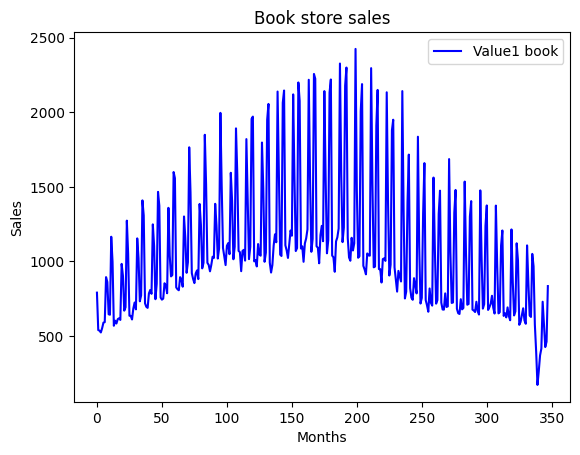

In [17]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales[:, 0], 'b-', label='Value1 book')  # Plotting the second column (Value1 book)
plt.title('Book store sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [18]:

import torch
from torch.utils.data import DataLoader

def train_model(model, device, epochs, batch_size, trainset, testset,
                optimizer, loss_function, metric):
    # Transfer model to GPU.
    model.to(device)

    # Create dataloaders.
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    acc = False
    mae = False
    if(metric == 'acc'):
        acc = True
    elif(metric == 'mae'):
        mae = True
    else:
        print('Error: unsupported metric')
        return

    for i in range(epochs):
        model.train() # Set model in training mode.
        train_loss = 0.0
        if(acc):
            train_correct = 0
        if(mae):
            train_absolute_error = 0.0
        train_batches = 0
        for inputs, targets in trainloader:
            # Move data to GPU.
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward pass.
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # Accumulate metrics.
            if(acc):
                _, indices = torch.max(outputs.data, 1)
                train_correct += (indices == targets).sum().item()
            if(mae):
                train_absolute_error += (targets - outputs.data).abs().sum().item()
            train_batches +=  1
            train_loss += loss.item()

            # Backward pass and update.
            loss.backward()
            optimizer.step()

        train_loss = train_loss / train_batches
        if(acc):
            train_acc = train_correct / (train_batches * batch_size)
        if(mae):
            train_mae = train_absolute_error / (train_batches * batch_size)

        # Evaluate the model on the test dataset.
        model.eval() # Set model in inference mode.
        test_loss = 0.0
        if(acc):
            test_correct = 0
        if(mae):
            test_absolute_error = 0.0
        test_batches = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            if(acc):
                _, indices = torch.max(outputs.data, 1)
                test_correct += (indices == targets).sum().item()
            if(mae):
                test_absolute_error += (targets - outputs.data).abs().sum().item()
            test_batches +=  1
            test_loss += loss.item()
        test_loss = test_loss / test_batches
        if(acc):
            test_acc = test_correct / (test_batches * batch_size)
            print(f'Epoch {i+1}/{epochs} loss: {train_loss:.4f} - acc: {train_acc:0.4f} - val_loss: {test_loss:.4f} - val_acc: {test_acc:0.4f}')
            return_value = [train_acc, test_acc]
        if(mae):
            test_mae = test_absolute_error / (test_batches * batch_size)
            print(f'Epoch {i+1}/{epochs} loss: {train_loss:.4f} - mae: {train_mae:0.4f} - val_loss: {test_loss:.4f} - val_mae: {test_mae:0.4f}')
            return_value = [train_mae, test_mae]
    return return_value

For comparison purposes, create output corresponding to a naive model that predicts that the sales next month will be the same as the sales this month. Compare this to the correct data by plotting the values side by side.


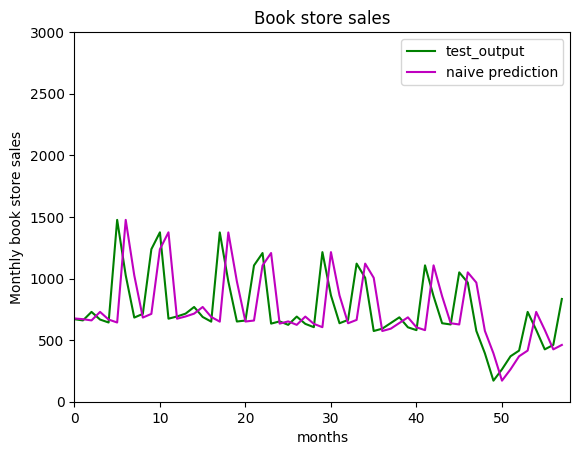

In [19]:
# Plot naive prediction for book sales
test_output = test_sales[MIN:, 0]  # Extracting only the book sales from test data
naive_prediction = test_sales[MIN-1:-1, 0]  # Extracting only the book sales from the naive prediction
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])  # Adjust the y-axis limit according to your data
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()


The next step is to standardize the data points by subtracting the mean and dividing by the standard deviation of the training examples.


In [20]:
# Standardize the data
mean = np.mean(train_sales, axis=0)
stddev = np.std(train_sales, axis=0)
train_sales_std = (train_sales - mean) / stddev
test_sales_std = (test_sales - mean) / stddev

In [21]:
mean

array([1148.1007, 2446.2878, 5711.748 , 1296.8489], dtype=float32)

In our previous examples, the datasets were already organized into individual examples. For example, we had an array of images serving as input values and an associated array of classes serving as expected output values. However, the data that we created in this example is raw historical data and not yet organized as a set of training and test examples (see figures 9-8 and 9-9 and the surrounding text in the book for more details of how we need it organized). This is the next step in our code example. The code snippet below allocates NumPy arrays for the training data and initializes all entries to 0. It then loops through the historical data and creates training examples, then does the same thing with the test data.

Finally we convert the data into PyTorch tensors and create Dataset objects.


In [22]:
# Create train examples.
train_months = len(train_sales)
num_features = 4  # Number of features in your dataset
train_X = np.zeros((train_months-MIN, MIN, num_features), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months - MIN):
    # Include all features in the sequences
    train_X[i] = train_sales_std[i:i+MIN, :]  # All features are included
    # Target is the book sales of the next month (assuming first column is book sales)
    train_y[i] = train_sales_std[i + MIN, 0]  # Adjusted to target book sales specifically

# Create test examples with a similar adjustment
test_months = len(test_sales_std)  # Adjusted for standardized data
test_X = np.zeros((test_months - MIN, MIN, num_features), dtype=np.float32)
test_y = np.zeros((test_months - MIN, 1), dtype=np.float32)  # Predicting book sales

for i in range(0, test_months - MIN):
    test_X[i] = test_sales_std[i:i+MIN, :]  # Including all features
    test_y[i] = test_sales_std[i + MIN, 0]  # Targeting book sales

# Convert to TensorDataset objects for use with PyTorch DataLoader
trainset = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X), torch.from_numpy(test_y))

In [23]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((266, 12, 4), (266, 1), (58, 12, 4), (58, 1))

We are finally ready to define and train our network. This is shown in the code snippet below.

The code snippet introduces a new type of construct. At the very top we create a custom layer by defining a class LastTimestep that extends the nn.Module class. Although we did not explicitly mention it, the layers that we have used in other examples (e.g., Linear, Conv2d, Flatten, and ReLU) were all subclasses of the nn.Module class. The only thing we need to do to create a custom layer based on nn.Module is to provide our own forward() method. This method will be called with the layer inputs as parameter when the layer is invoked. The method is expected to return the resulting output.

In order to explain why we need to implement this custom layer, we first need to describe some details of the nn.RNN class used to implement recurrent networks in PyTorch. The nn.RNN class is not simply a single recurrent layer, but it implements a stack of recurrent layers, where the number of layers is determined by the first parameter to the constructor. When an instance of nn.RNN is called, it returns a tuple with two elements. The first element in the tuple is a tensor that contains the output value of the top layer for each timestep. The second element in the tuple is a tensor that contains the final output value for each of the layers. Note that since the nn.RNN module will receive a full mini-batch as input, one of the dimensions for these tensors is used to specify which training/test example in a mini-batch to access. If the batch_first argument to the constructor is set to True, then index 0 in the tensor corresponds to the mini-batch index.

In our case, we want a single recurrent layer, and we want the final output value of this single layer to be fed to a fully connected (Linear) layer. This is why we build the custom layer. Its only task is to retrieve the right data value and drop the others on the floor. This is done by first selecting the second element in the tuple (index 1), which results in a tensor containing the final output value for each layer. From this tensor we now retrieve the value corresponding to the top layer (index 0 since our RNN will only have a single recurrent layer).

We can now create our full model by starting with an nn.RNN with a single layer and 128 units. The nn.RNN class does include the ability to select what activation function to use and we specify ReLU. The RNN module is followed by our custom layer that then feeds into a Linear layer with 128 inputs and a single output. The number of inputs (128) must match the number of outputs from the preceding layer.

As usual, we then select an optimizer and a loss function, before calling our training function to train the model.


In [26]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
    def forward(self, inputs):
        return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(input_size=4, hidden_size=128, num_layers=2, nonlinearity='relu',
           batch_first=True, dropout=0.3), # added dropout to reduce overfitting
    LastTimestep(),
    nn.Linear(128, 1)
).to(device)

# Loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model.
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset,
            optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.8488 - mae: 0.6508 - val_loss: 1.1719 - val_mae: 0.8591
Epoch 2/100 loss: 0.6085 - mae: 0.5486 - val_loss: 0.7931 - val_mae: 0.6969
Epoch 3/100 loss: 0.4804 - mae: 0.4807 - val_loss: 1.1656 - val_mae: 0.8769
Epoch 4/100 loss: 0.3835 - mae: 0.4604 - val_loss: 0.5829 - val_mae: 0.5542
Epoch 5/100 loss: 0.2508 - mae: 0.3689 - val_loss: 0.3140 - val_mae: 0.3743
Epoch 6/100 loss: 0.1579 - mae: 0.3099 - val_loss: 0.2722 - val_mae: 0.3632
Epoch 7/100 loss: 0.0988 - mae: 0.2333 - val_loss: 0.2379 - val_mae: 0.3257
Epoch 8/100 loss: 0.0599 - mae: 0.1822 - val_loss: 0.1887 - val_mae: 0.2809
Epoch 9/100 loss: 0.0353 - mae: 0.1406 - val_loss: 0.1438 - val_mae: 0.2324
Epoch 10/100 loss: 0.0280 - mae: 0.1227 - val_loss: 0.1396 - val_mae: 0.2232
Epoch 11/100 loss: 0.0277 - mae: 0.1219 - val_loss: 0.1404 - val_mae: 0.2237
Epoch 12/100 loss: 0.0263 - mae: 0.1159 - val_loss: 0.1090 - val_mae: 0.1807
Epoch 13/100 loss: 0.0265 - mae: 0.1176 - val_loss: 0.1638 - val_mae: 0.2482
Epoch 14

[0.06767289713025093, 0.19683852419257164]

The train_model() function will report the loss (mean squared error) and the resulting mean absolute error (since it is a regression problem). In order to get an idea of if these values are good or bad, we can compare to the corresponding metrics for the naive model described further up (that predicted that tomorrow's value is the same as today's). However, because our model works on standardized data, we need to compute the MSE and MAE for the naive model on standardized data as well. This is done in the code snippet below.


In [25]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


naive test mse:  0.7983826
naive test mean abs:  0.5774085


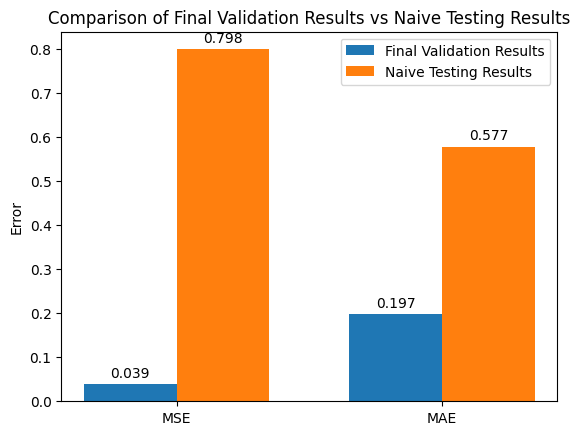

In [28]:
import matplotlib.pyplot as plt

# Final validation results
final_val_mae = 0.19683852419257164

# Convert MAE to MSE
final_val_mse = final_val_mae ** 2

# Naive testing results
naive_test_mse = 0.7983826
naive_test_mae = 0.5774085

# Plotting
metrics = ['MSE', 'MAE']
final_val_errors = [final_val_mse, final_val_mae]
naive_test_errors = [naive_test_mse, naive_test_mae]

x = list(range(len(metrics)))  # Convert range to list
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar([val - width/2 for val in x], final_val_errors, width, label='Final Validation Results')  # Adjust x positions
rects2 = ax.bar([val + width/2 for val in x], naive_test_errors, width, label='Naive Testing Results')  # Adjust x positions

ax.set_ylabel('Error')
ax.set_title('Comparison of Final Validation Results vs Naive Testing Results')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to annotate bars with their values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),  # Round to 3 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


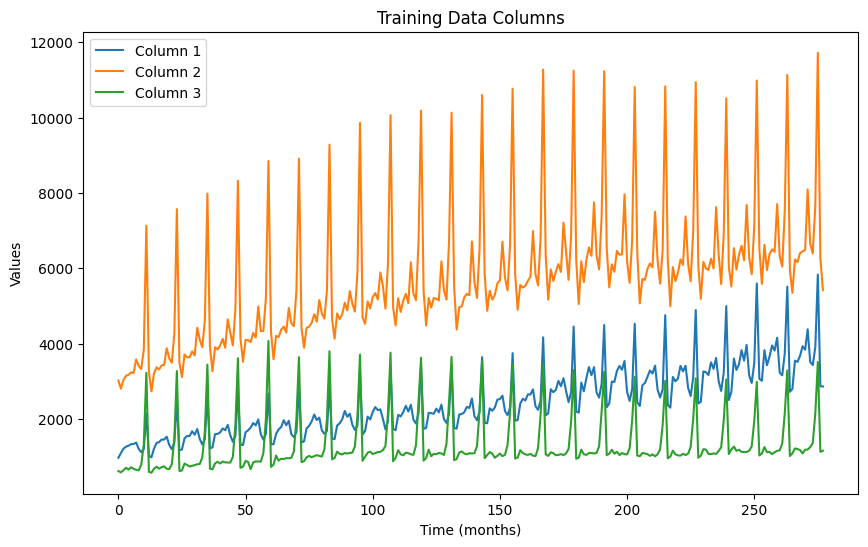

In [29]:
# Plot train sales columns
num_columns = train_sales.shape[1]  # Get the number of columns in train_sales
x = np.arange(len(train_sales))

plt.figure(figsize=(10, 6))
for i in range(1, num_columns):
    plt.plot(x, train_sales[:, i], label=f'Column {i}')

plt.title('Training Data Columns')
plt.xlabel('Time (months)')
plt.ylabel('Values')
plt.legend()
plt.show()


In [30]:
print(train_sales)


[[  790.   972.  3023.   620.]
 [  539.  1100.  2806.   585.]
 [  535.  1214.  3040.   643.]
 ...
 [ 1326.  5836. 11724.  3516.]
 [ 1479.  2871.  6250.  1130.]
 [  682.  2864.  5424.  1160.]]


To shed some light on how this affects the end behavior, let us use our newly trained model to do some predictions and then plot these predictions next to the actual values. The code snippet below demonstrates how this can be done.

We start with our test data which exists as a NumPy array in the variable test_X. We convert it to a PyTorch tensor with a call to torch.from_numpy(). We then move it to the GPU and use it as input to our model. This produces an output tensor with a single value for each test example. We move this tensor back to the CPU, and then call detach() and numpy() to convert it back to NumPy format. The call to detach() will create a tensor for which gradients can no longer be automatically computed. It is a necessary step before converting the tensor into NumPy format.

We then reshape the data into a 2D array. The network works with standardized data, so the output will not represent sales directly. We must first destandardize the data by doing the reverse operation compared to the standardization. That is, we multiply by the standard deviation and add the mean. We then plot the data.


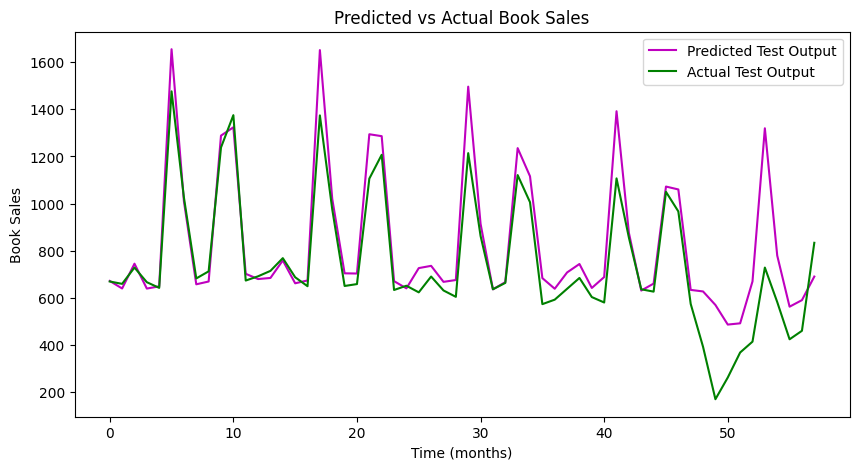

In [31]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X).float()  # Ensure input is in float
inputs = inputs.to(device)
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Inference without gradient calculation
    outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output.
# Here, '0' should correspond to the index of book sales in your standard deviation and mean arrays
predicted_test = predicted_test * stddev[0] + mean[0]

# Plot test prediction.
# Use the actual number of predictions for the x-axis
x = np.arange(len(predicted_test))
# Ensure you have the correct slice for the actual sales
actual_sales = test_sales_std[MIN:, 0] * stddev[0] + mean[0]  # De-standardize the actual book sales

plt.figure(figsize=(10, 5))  # Optional: Set a figure size for better readability
plt.plot(x, predicted_test, 'm-', label='Predicted Test Output')
plt.plot(x, actual_sales, 'g-', label='Actual Test Output')
plt.title('Predicted vs Actual Book Sales')
plt.xlabel('Time (months)')
plt.ylabel('Book Sales')
plt.legend()
plt.show()


For some more discussion about how the observed numerical values relate to each other and a comparison between an RNN based model and a feed-forward model, see the "Programming Example: Forecasting Book Sales" section in Chapter 9, which describes the results observed for an equivalent implementation in TensorFlow.
